In [17]:
import numpy as np
import matplotlib.pyplot as plt

### Adjacency Matricies

In [24]:
def random_connectivity_matrix(n, med_frac = 1.0, source_rate = 0.1, all_source_connections = 0, random_state = 10):
    rng = np.random.RandomState(random_state) # fixed random state
    
    A = rng.rand(n, n)
    A = np.dot(A.T, A)
    np.fill_diagonal(A, 0)
    K = A.copy()

    for i in range(n):
        loc_thresh = min(med_frac * np.median(A[i, 1:]), max(A[i, 1:] * 0.99))
        ind = A[i, 1:] < loc_thresh
        ind = np.insert(ind, 0, False)
        K[i, ind] = 0
        K[ind, i] = 0

    S = np.sum(K > 0.0, axis=0)
    for i in range(n):
        if S[i] == 0 or (i == 1 and S[i] < 2):
            if i != 1:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 1:]))
                K[i, ind + 1] = val
                K[ind + 1, i] = val
            else:
                val, ind = max((val, idx) for idx, val in enumerate(A[i, 2:]))
                K[i, ind + 2] = val
                K[ind + 2, i] = val

    K /= np.max(K)
    if all_source_connections:
        K[0, :] = source_rate
        K[:, 0] = source_rate
    else:
        K[0, :] = 0.0
        K[:, 0] = 0.0

    K[0, 1] = source_rate
    K[1, 0] = source_rate

    return K

def random_zero_diagonal_matrix(size, random_state = 10):
    """Generates an adjacency matrix with zero diagonal."""
    rng = np.random.RandomState(random_state) # fixed random state
    A = rng.rand(size, size)
    np.fill_diagonal(A, 0)
    return A

def binary_zero_diagonal_matrix(size):
    """Generates an adjacency matrix with zero diagonal."""
    A = np.ones([size, size])
    np.fill_diagonal(A, 0)
    return A

def tridiagonal_matrix(size):
    """Generates a binary tridiagonal adjacency matrix with zero diagonal."""
    A = np.zeros((size, size))
    np.fill_diagonal(A[:-1, 1:], 1)
    np.fill_diagonal(A[1:, :-1], 1)
    return A

def generate_laplacian_matrix(A):
    """Generates the Laplacian matrix from the adjacency matrix as described by Garbarino."""
    degree_matrix = np.diag(np.sum(A, axis=1))
    laplacian_matrix = degree_matrix - A
    return laplacian_matrix

def binary_random_connections(size, max_connections, random_state=42):
    rng = np.random.RandomState(random_state)
    A = np.zeros((size, size), dtype=int)
    for i in range(size):
        connections = rng.choice(size, max_connections, replace=False)
        A[i, connections] = 1
    np.fill_diagonal(A, 0)
    return A

In [23]:
size = 3

A_random = random_connectivity_matrix(size)
print(f"random_connectivity_matrix:\n{A_random}")

A_random_zero_diag = random_zero_diagonal_matrix(size)
print(f"\nrandom_zero_diagonal_matrix:\n{A_random_zero_diag}")

A_binary_zero = binary_zero_diagonal_matrix(size)
print(f"\nbinary_zero_diagonal_matrix:\n{A_binary_zero}")

A_tridiagonal = tridiagonal_matrix(size)
print(f"\ntridiagonal_matrix:\n{A_tridiagonal}")

A_random_connections = binary_random_connections(size, 2)
print(f"\binary_random_connections:\n{A_random_connections}")

A_full = binary_fully_connected(size)
print(f"\binary_fully_connected:\n{A_full}")

random_connectivity_matrix:
[[0.         0.1        0.        ]
 [0.1        0.         0.36756077]
 [0.         0.36756077 0.        ]]

random_zero_diagonal_matrix:
[[0.         0.02075195 0.63364823]
 [0.74880388 0.         0.22479665]
 [0.19806286 0.76053071 0.        ]]

binary_zero_diagonal_matrix:
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]

tridiagonal_matrix:
[[0. 1. 0.]
 [1. 0. 1.]
 [0. 1. 0.]]
inary_random_connections:
[[0 1 0]
 [0 0 1]
 [1 1 0]]
inary_fully_connected:
[[0. 1. 1.]
 [1. 0. 1.]
 [1. 1. 0.]]


### Compute Laplacian

In [4]:
def compute_laplacian(A):
    """Generates the Laplacian matrix from the adjacency matrix as described by Garbarino."""
    degree_matrix = np.diag(np.sum(A, axis=1))
    laplacian_matrix = degree_matrix - A
    return laplacian_matrix

L_random = compute_laplacian(A_random)
print(f"random_connectivity_matrix:\n{L_random}")

L_random_zero_diag = compute_laplacian(A_random_zero_diag)
print(f"\nrandom_zero_diagonal_matrix:\n{L_random_zero_diag}")

L_binary_zero = compute_laplacian(A_binary_zero)
print(f"\nbinary_zero_diagonal_matrix:\n{L_binary_zero}")

L_tridiagonal = compute_laplacian(A_tridiagonal)
print(f"\ntridiagonal_matrix:\n{L_tridiagonal}")

random_connectivity_matrix:
[[ 0.1        -0.1         0.        ]
 [-0.1         0.46756077 -0.36756077]
 [ 0.         -0.36756077  0.36756077]]

random_zero_diagonal_matrix:
[[ 0.65440018 -0.02075195 -0.63364823]
 [-0.74880388  0.97360053 -0.22479665]
 [-0.19806286 -0.76053071  0.95859358]]

binary_zero_diagonal_matrix:
[[ 2. -1. -1.]
 [-1.  2. -1.]
 [-1. -1.  2.]]

tridiagonal_matrix:
[[ 1. -1.  0.]
 [-1.  2. -1.]
 [ 0. -1.  1.]]


### Diffusion Model

In [5]:
def diffusion_model(A, H, k_ij_mean, random_state=None):
    np.random.seed(random_state)
    
    n = A.shape[0]
    t = np.linspace(0, 100, 200)
    dt = t[1] - t[0]  # time step
    x = np.zeros((n, len(t)))
    x[:, 0] = np.ones(n) * 0.1 + np.random.normal(0, 0.01, n)
    x[0, 0] = 0.1  # set the initial condition for the first biomarker
    
    k_ij = np.random.normal(k_ij_mean, 0.1, n)
    K = np.diag(k_ij)
    
    # forward euler method
    for i in range(1, len(t)):
        dfdtau = -np.dot(np.dot(A * K, H), x[:, i-1])
        x[:, i] = x[:, i-1] + dfdtau * dt
    
    return t, x

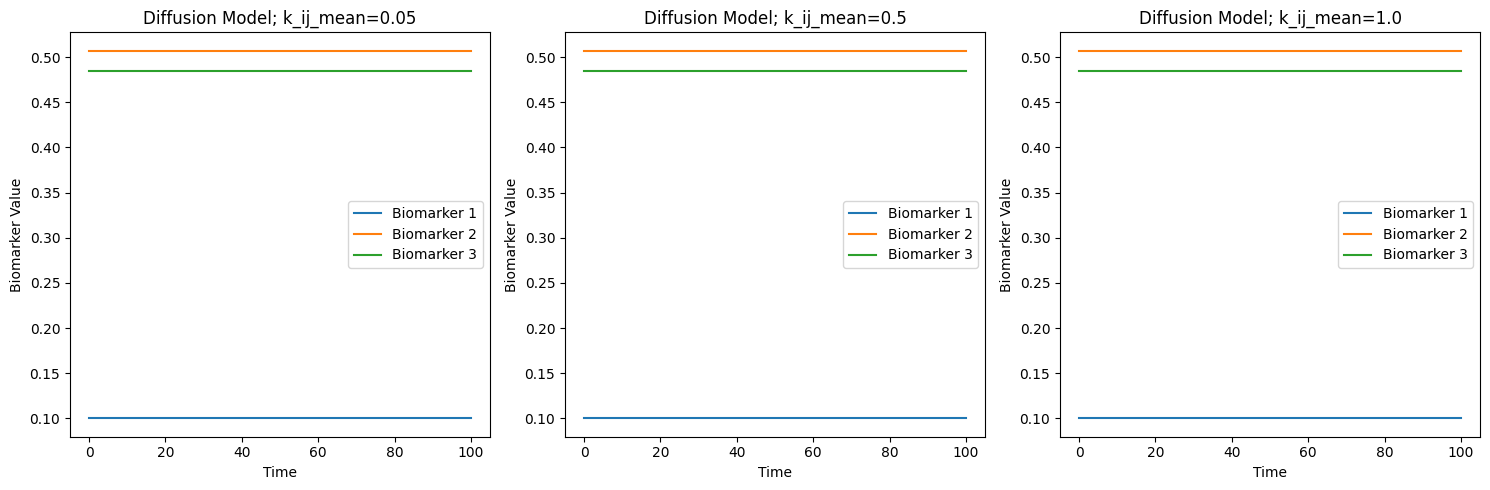

In [25]:
# Example of plotting the Diffusion model with different parameter sets
size = 3
A = tridiagonal_matrix(size)
H = compute_laplacian(A)

parameter_sets = [
    {'k_ij_mean': 0.05},
    {'k_ij_mean': 0.5},
    {'k_ij_mean': 1.0}
]

# Set up a 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Run the model for each parameter set and plot the results in subplots
for idx, params in enumerate(parameter_sets):
    t, x = diffusion_model(A, H, **params, random_state=10)
    ax = axes[idx]
    
    for i in range(size):
        ax.plot(t, x[i], label=f'Biomarker {i+1}')
    
    # Create a title with the k_ij parameter
    title = f"Diffusion Model; k_ij_mean={params['k_ij_mean']}"
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Biomarker Value')
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

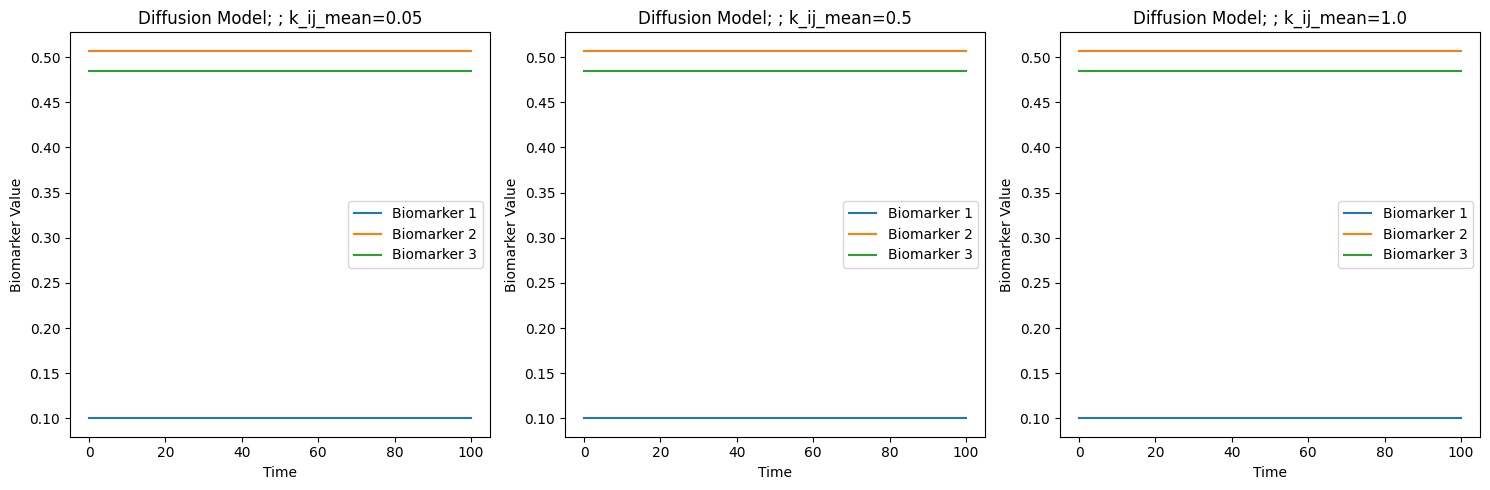

In [26]:
# Example of plotting the Diffusion model with different parameter sets
size = 3
A = random_zero_diagonal_matrix(size, random_state=10)
H = compute_laplacian(A)

parameter_sets = [
    {'k_ij_mean': 0.05},
    {'k_ij_mean': 0.5},
    {'k_ij_mean': 1.0}
]

# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, params in enumerate(parameter_sets):
    t, x = diffusion_model(A, H, **params, random_state=10)
    ax = axes[idx]
    
    for i in range(size):
        ax.plot(t, x[i], label=f'Biomarker {i+1}')
    
    title = f"Diffusion Model; ; k_ij_mean={params['k_ij_mean']}"
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Biomarker Value')
    ax.legend()

plt.tight_layout()
plt.show()

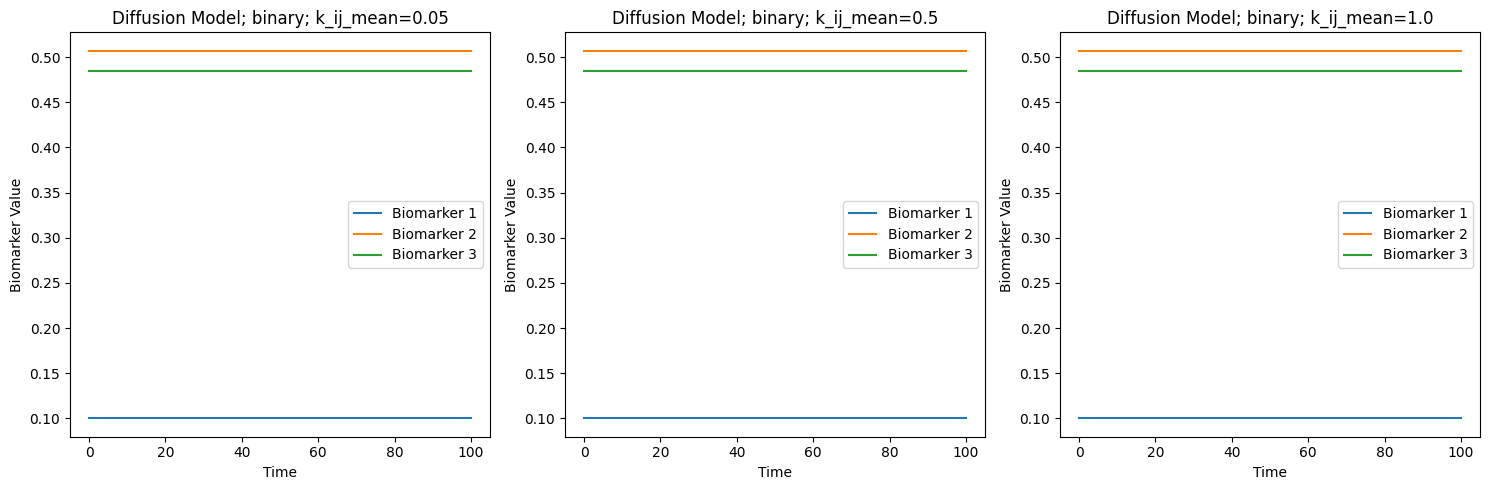

In [27]:
size = 3
A = binary_zero_diagonal_matrix(size)
H = compute_laplacian(A)

parameter_sets = [
    {'k_ij_mean': 0.05},
    {'k_ij_mean': 0.5},
    {'k_ij_mean': 1.0}
]

# 1x3 grid of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for idx, params in enumerate(parameter_sets):
    t, x = diffusion_model(A, H, **params, random_state=10)
    ax = axes[idx]
    
    for i in range(size):
        ax.plot(t, x[i], label=f'Biomarker {i+1}')
    
    title = f"Diffusion Model; binary; k_ij_mean={params['k_ij_mean']}"
    ax.set_title(title)
    ax.set_xlabel('Time')
    ax.set_ylabel('Biomarker Value')
    ax.legend()

plt.tight_layout()
plt.show()